### Task : Implement the Neural Style Transfer algorithm and generate A.I. Art ! with TF2

In [1]:
import os
import sys
import scipy.io
import imageio
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import tensorflow as tf

%matplotlib inline
%config Completer.use_jedi = False

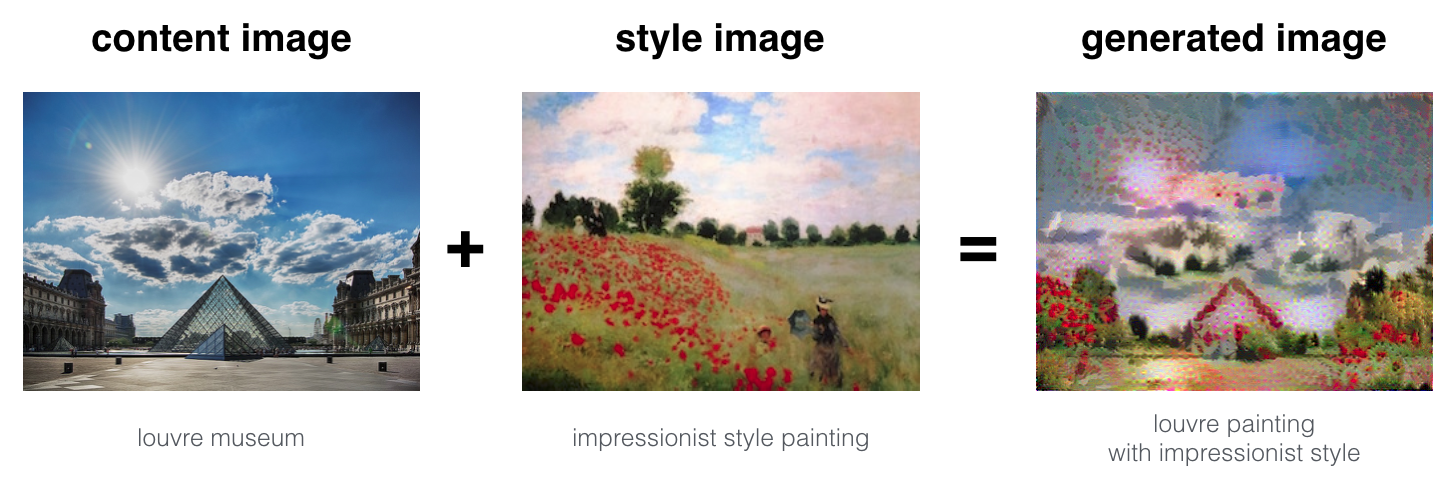

In [2]:
from nst_utils import * 
from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input,decode_predictions
from keras.models import Model

## The model

In [3]:
model = VGG19(weights='imagenet',include_top = False)

In [4]:
model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [5]:
def load_image(location,target_size=None):
    """
    provide a location and output a numpy image.
    """
    img = Image.open(location)
    if target_size == None:     
        return np.array(img)
    else:
        img = np.array(img.resize(target_size))
        return img

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import io
import base64
from IPython.display import HTML

def plot_image_grid(images,num_rows=1):
    """
    input a list of images and it plots them with num_rows rows."""
    n= len(images)
    num_cols = np.ceil(n/num_rows)
    fig,axes = plt.subplots(ncols=int(num_cols),nrows=int(num_rows))
    axes = axes.flatten()
    fig.set_size_inches((15,15))
    for i,image in enumerate(images):
        axes[i].imshow(image)

def place_video(location_of_video):
    """
    location_of_video: location of mp4 video"""
    video = io.open(location_of_video, 'r+b').read()
    encoded = base64.b64encode(video)
    return HTML(data='''<video alt="test" controls><source src="data:video/mp4;base64,{0}" type="video/mp4" /></video>'''.format(encoded.decode('ascii')))
    

In [76]:
wave_loc = 'images/starry_night.jpeg'
golden_gate_loc = 'images/GoldenGate.jpeg'

## The images : 

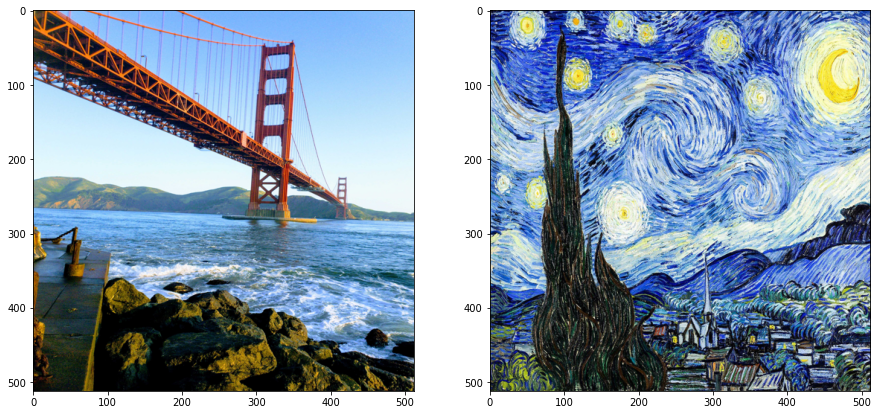

In [77]:
golden_gate_img = load_image(golden_gate_loc,target_size = (512,512))
wave_img = load_image(wave_loc,target_size = (512,512))
plot_image_grid([golden_gate_img,wave_img])

In [78]:
CONTENT_LAYERS = ['block5_conv2']
OUTPUT_LAYERS = ["block4_conv1","block4_conv2","block4_conv3","block4_conv4"]

In [79]:
def make_model(include_full = False, input_shape = None) : 
    
    if include_full:
        base_model = VGG19(include_top=True,weights = 'imagenet')
        return base_model
    if input_shape != None : 
        base_model = VGG19(include_top=False,input_shape = input_shape,weights = 'imagenet')
    else: 
        base_model = VGG19(include_top=False,weights = 'imagenet')
    base_model.trainable = False
    content_layers = CONTENT_LAYERS
    style_layers = OUTPUT_LAYERS
    output_layers = [base_model.get_layer(layer).output for layer in (content_layers + style_layers)]
    return tf.keras.models.Model(base_model.input,output_layers)

## Let's make our base model for NST

In [80]:
style_img = wave_img
content_img = golden_gate_img

In [81]:
content_img_noised = content_img + np.random.randn(*content_img.shape)*10
content_img_noised=  content_img_noised.astype('float32')

In [82]:
processed_wave = preprocess_input(np.expand_dims(wave_img,axis = 0))

In [83]:
processed_golden_gate = preprocess_input(np.expand_dims(golden_gate_img,axis = 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


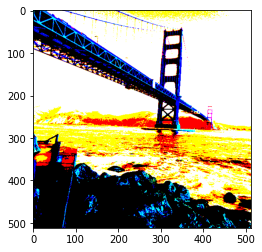

In [84]:
# processed_golden_gate
plt.imshow(processed_golden_gate.reshape((512,512,3)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


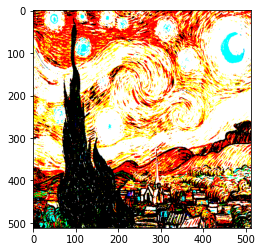

In [85]:
# processed starry nights
plt.imshow(processed_wave.reshape((512,512,3)))

In [86]:
processed_golden_gate.shape

(1, 512, 512, 3)

## VGG takes the image and applies a bias to it as well as changes RGB channels to BGR channels

In [87]:
VGG_BIASES = preprocess_input((np.zeros((3))).astype('float32'))

In [88]:
# changing RGB to BGR using tf.unstack and then tf.stack
def deprocess(processed_img) : 
    unprocessed_img = processed_img - VGG_BIASES
    unprocessed_img = tf.unstack(unprocessed_img,axis = -1)
    unprocessed_img = tf.stack([unprocessed_img[2],unprocessed_img[1],unprocessed_img[0]],axis = -1)
    return unprocessed_img

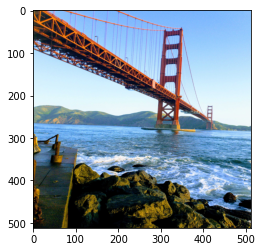

In [89]:
plt.imshow(np.round(deprocess(processed_golden_gate)[0])/255)

## Let's see the outputs from base model

In [90]:
base_model = make_model()

In [91]:
golden_gate_outputs = base_model(processed_golden_gate)
wave_outputs = base_model(processed_wave)

In [92]:
golden_gate_content = golden_gate_outputs[0]
wave_content = wave_outputs[0]

### Content loss

In [93]:
def get_content_loss(new_image_content,base_image_content) : 
    return np.mean(np.square(new_image_content - base_image_content))

### Style loss

The NN can be understood as pulling out the basis of content and style

In [94]:
def get_gram_matrix(output):
    first_style_layer = output
    A = tf.reshape(first_style_layer,(-1,first_style_layer.shape[-1])) 
    n = A.shape[0]
    gram_matrix = tf.matmul(A,A,transpose_a=True)
    n=gram_matrix.shape[0]
    return gram_matrix/tf.cast(n,"float32"),n

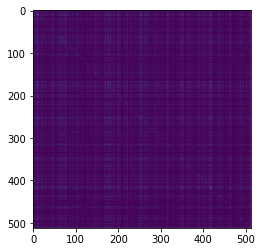

In [95]:
gram_matrix,N = get_gram_matrix(wave_outputs[2])
plt.imshow(gram_matrix.numpy())

In [96]:
def get_style_loss(new_image_style,base_style):
    new_style_gram,gram_num_height = get_gram_matrix(new_image_style)
    base_style_gram,gram_num_height2 = get_gram_matrix(base_style)
    assert gram_num_height == gram_num_height2
    gram_num_features = new_style_gram.shape[0]
    loss=tf.reduce_sum(tf.square(base_style_gram-new_style_gram)/(4*(gram_num_height**2)*(gram_num_features**2)))
    return loss

## Let's get the total loss now

In [97]:
def get_total_loss(new_image_output,base_content_image_output,base_style_image_output,alpha=.999):
    new_image_styles = new_image_output[len(CONTENT_LAYERS):]
    base_image_styles = base_style_image_output[len(CONTENT_LAYERS):]
    style_loss=0
    N = len(new_image_styles)
    for i in range(N):
        style_loss+=get_style_loss(new_image_styles[i],base_image_styles[i])
    
    new_image_contents = new_image_output[:len(CONTENT_LAYERS)]
    base_image_contents = base_content_image_output[:len(CONTENT_LAYERS)]
    content_loss = 0
    N = len(new_image_contents)
    for i in range(N):
        content_loss+=get_content_loss(new_image_contents[i],base_image_contents[i])/N
    
    return (1-alpha)*style_loss+alpha*content_loss   

In [98]:
get_total_loss(wave_outputs,golden_gate_outputs,wave_outputs)

<tf.Tensor: shape=(), dtype=float32, numpy=6900.128>

## Let's finally do the training

Neural Style Transfer is different as we apply gradient descent on the weights of edges on a neural network. However, in NST we are applying optimization on our input and instead of updating weights, we update the input

In [99]:
base_style_outputs  = base_model(processed_wave)

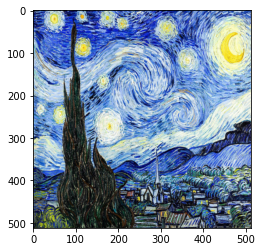

In [100]:
# The style image
plt.imshow(deprocess(processed_wave)[0]/255)

In [101]:
base_content_output = base_model(processed_golden_gate)

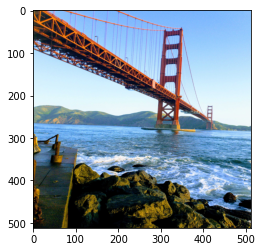

In [102]:
# The content image
plt.imshow(deprocess(processed_golden_gate)[0]/255)

In [103]:
processed_content_var = tf.Variable(processed_golden_gate + tf.random.normal(processed_golden_gate.shape))

In [104]:
optimizer = tf.optimizers.Adam(5,beta_1 = .99,epsilon = 1e-3)

In [105]:
from IPython.display import display,clear_output

In [106]:
images = []
losses = []

In [50]:
i=0
best_loss =200000
min_vals = VGG_BIASES
max_vals = 255+VGG_BIASES
for i in range(200):   
    print('epoch : ' + str(i))
    with tf.GradientTape() as tape:
        tape.watch(processed_content_var)
        content_var_outputs = base_model(processed_content_var)
        loss = get_total_loss(content_var_outputs,base_content_output,base_style_outputs,alpha=.97)
        grad = tape.gradient(loss,processed_content_var)
        losses.append(loss)
        optimizer.apply_gradients(zip([grad],[processed_content_var]))
        clipped = tf.clip_by_value(processed_content_var, min_vals, max_vals)
        processed_content_var.assign(clipped)
        if i%5 ==0:
            images.append(deprocess(processed_content_var))
        if loss<best_loss:
            best_image = processed_content_var
            best_loss=loss
        display(loss)


epoch : 0


<tf.Tensor: shape=(), dtype=float32, numpy=75523.07>

epoch : 1


<tf.Tensor: shape=(), dtype=float32, numpy=70081.48>

epoch : 2


<tf.Tensor: shape=(), dtype=float32, numpy=62406.875>

epoch : 3


<tf.Tensor: shape=(), dtype=float32, numpy=53935.1>

epoch : 4


<tf.Tensor: shape=(), dtype=float32, numpy=46227.55>

epoch : 5


<tf.Tensor: shape=(), dtype=float32, numpy=40166.51>

epoch : 6


<tf.Tensor: shape=(), dtype=float32, numpy=35853.023>

epoch : 7


<tf.Tensor: shape=(), dtype=float32, numpy=32931.344>

epoch : 8


<tf.Tensor: shape=(), dtype=float32, numpy=30941.018>

epoch : 9


<tf.Tensor: shape=(), dtype=float32, numpy=29514.262>

epoch : 10


<tf.Tensor: shape=(), dtype=float32, numpy=28335.596>

epoch : 11


<tf.Tensor: shape=(), dtype=float32, numpy=27200.549>

epoch : 12


<tf.Tensor: shape=(), dtype=float32, numpy=26049.664>

epoch : 13


<tf.Tensor: shape=(), dtype=float32, numpy=24965.076>

epoch : 14


<tf.Tensor: shape=(), dtype=float32, numpy=24043.379>

epoch : 15


<tf.Tensor: shape=(), dtype=float32, numpy=23323.857>

epoch : 16


<tf.Tensor: shape=(), dtype=float32, numpy=22810.84>

epoch : 17


<tf.Tensor: shape=(), dtype=float32, numpy=22455.242>

epoch : 18


<tf.Tensor: shape=(), dtype=float32, numpy=22185.566>

epoch : 19


<tf.Tensor: shape=(), dtype=float32, numpy=21914.535>

epoch : 20


<tf.Tensor: shape=(), dtype=float32, numpy=21537.209>

epoch : 21


<tf.Tensor: shape=(), dtype=float32, numpy=20990.854>

epoch : 22


<tf.Tensor: shape=(), dtype=float32, numpy=20283.73>

epoch : 23


<tf.Tensor: shape=(), dtype=float32, numpy=19493.04>

epoch : 24


<tf.Tensor: shape=(), dtype=float32, numpy=18720.652>

epoch : 25


<tf.Tensor: shape=(), dtype=float32, numpy=18040.52>

epoch : 26


<tf.Tensor: shape=(), dtype=float32, numpy=17483.496>

epoch : 27


<tf.Tensor: shape=(), dtype=float32, numpy=17033.072>

epoch : 28


<tf.Tensor: shape=(), dtype=float32, numpy=16658.258>

epoch : 29


<tf.Tensor: shape=(), dtype=float32, numpy=16322.356>

epoch : 30


<tf.Tensor: shape=(), dtype=float32, numpy=16012.703>

epoch : 31


<tf.Tensor: shape=(), dtype=float32, numpy=15725.504>

epoch : 32


<tf.Tensor: shape=(), dtype=float32, numpy=15464.965>

epoch : 33


<tf.Tensor: shape=(), dtype=float32, numpy=15225.281>

epoch : 34


<tf.Tensor: shape=(), dtype=float32, numpy=15000.86>

epoch : 35


<tf.Tensor: shape=(), dtype=float32, numpy=14787.707>

epoch : 36


<tf.Tensor: shape=(), dtype=float32, numpy=14591.464>

epoch : 37


<tf.Tensor: shape=(), dtype=float32, numpy=14419.625>

epoch : 38


<tf.Tensor: shape=(), dtype=float32, numpy=14280.502>

epoch : 39


<tf.Tensor: shape=(), dtype=float32, numpy=14178.279>

epoch : 40


<tf.Tensor: shape=(), dtype=float32, numpy=14110.299>

epoch : 41


<tf.Tensor: shape=(), dtype=float32, numpy=14063.719>

epoch : 42


<tf.Tensor: shape=(), dtype=float32, numpy=14021.531>

epoch : 43


<tf.Tensor: shape=(), dtype=float32, numpy=13961.268>

epoch : 44


<tf.Tensor: shape=(), dtype=float32, numpy=13868.619>

epoch : 45


<tf.Tensor: shape=(), dtype=float32, numpy=13731.369>

epoch : 46


<tf.Tensor: shape=(), dtype=float32, numpy=13547.91>

epoch : 47


<tf.Tensor: shape=(), dtype=float32, numpy=13325.336>

epoch : 48


<tf.Tensor: shape=(), dtype=float32, numpy=13076.973>

epoch : 49


<tf.Tensor: shape=(), dtype=float32, numpy=12821.521>

epoch : 50


<tf.Tensor: shape=(), dtype=float32, numpy=12575.605>

epoch : 51


<tf.Tensor: shape=(), dtype=float32, numpy=12356.278>

epoch : 52


<tf.Tensor: shape=(), dtype=float32, numpy=12176.048>

epoch : 53


<tf.Tensor: shape=(), dtype=float32, numpy=12039.785>

epoch : 54


<tf.Tensor: shape=(), dtype=float32, numpy=11945.332>

epoch : 55


<tf.Tensor: shape=(), dtype=float32, numpy=11885.064>

epoch : 56


<tf.Tensor: shape=(), dtype=float32, numpy=11843.596>

epoch : 57


<tf.Tensor: shape=(), dtype=float32, numpy=11805.309>

epoch : 58


<tf.Tensor: shape=(), dtype=float32, numpy=11754.72>

epoch : 59


<tf.Tensor: shape=(), dtype=float32, numpy=11683.229>

epoch : 60


<tf.Tensor: shape=(), dtype=float32, numpy=11588.978>

epoch : 61


<tf.Tensor: shape=(), dtype=float32, numpy=11477.414>

epoch : 62


<tf.Tensor: shape=(), dtype=float32, numpy=11359.471>

epoch : 63


<tf.Tensor: shape=(), dtype=float32, numpy=11246.393>

epoch : 64


<tf.Tensor: shape=(), dtype=float32, numpy=11146.574>

epoch : 65


<tf.Tensor: shape=(), dtype=float32, numpy=11063.703>

epoch : 66


<tf.Tensor: shape=(), dtype=float32, numpy=10997.252>

epoch : 67


<tf.Tensor: shape=(), dtype=float32, numpy=10943.6>

epoch : 68


<tf.Tensor: shape=(), dtype=float32, numpy=10899.39>

epoch : 69


<tf.Tensor: shape=(), dtype=float32, numpy=10859.408>

epoch : 70


<tf.Tensor: shape=(), dtype=float32, numpy=10817.486>

epoch : 71


<tf.Tensor: shape=(), dtype=float32, numpy=10766.061>

epoch : 72


<tf.Tensor: shape=(), dtype=float32, numpy=10699.209>

epoch : 73


<tf.Tensor: shape=(), dtype=float32, numpy=10612.521>

epoch : 74


<tf.Tensor: shape=(), dtype=float32, numpy=10507.045>

epoch : 75


<tf.Tensor: shape=(), dtype=float32, numpy=10388.09>

epoch : 76


<tf.Tensor: shape=(), dtype=float32, numpy=10265.001>

epoch : 77


<tf.Tensor: shape=(), dtype=float32, numpy=10147.201>

epoch : 78


<tf.Tensor: shape=(), dtype=float32, numpy=10043.23>

epoch : 79


<tf.Tensor: shape=(), dtype=float32, numpy=9957.912>

epoch : 80


<tf.Tensor: shape=(), dtype=float32, numpy=9891.085>

epoch : 81


<tf.Tensor: shape=(), dtype=float32, numpy=9839.791>

epoch : 82


<tf.Tensor: shape=(), dtype=float32, numpy=9797.387>

epoch : 83


<tf.Tensor: shape=(), dtype=float32, numpy=9757.756>

epoch : 84


<tf.Tensor: shape=(), dtype=float32, numpy=9714.895>

epoch : 85


<tf.Tensor: shape=(), dtype=float32, numpy=9664.551>

epoch : 86


<tf.Tensor: shape=(), dtype=float32, numpy=9606.579>

epoch : 87


<tf.Tensor: shape=(), dtype=float32, numpy=9542.34>

epoch : 88


<tf.Tensor: shape=(), dtype=float32, numpy=9474.917>

epoch : 89


<tf.Tensor: shape=(), dtype=float32, numpy=9407.473>

epoch : 90


<tf.Tensor: shape=(), dtype=float32, numpy=9342.586>

epoch : 91


<tf.Tensor: shape=(), dtype=float32, numpy=9282.777>

epoch : 92


<tf.Tensor: shape=(), dtype=float32, numpy=9229.184>

epoch : 93


<tf.Tensor: shape=(), dtype=float32, numpy=9181.844>

epoch : 94


<tf.Tensor: shape=(), dtype=float32, numpy=9141.057>

epoch : 95


<tf.Tensor: shape=(), dtype=float32, numpy=9106.131>

epoch : 96


<tf.Tensor: shape=(), dtype=float32, numpy=9076.017>

epoch : 97


<tf.Tensor: shape=(), dtype=float32, numpy=9048.708>

epoch : 98


<tf.Tensor: shape=(), dtype=float32, numpy=9020.592>

epoch : 99


<tf.Tensor: shape=(), dtype=float32, numpy=8987.723>

epoch : 100


<tf.Tensor: shape=(), dtype=float32, numpy=8946.982>

epoch : 101


<tf.Tensor: shape=(), dtype=float32, numpy=8897.18>

epoch : 102


<tf.Tensor: shape=(), dtype=float32, numpy=8838.818>

epoch : 103


<tf.Tensor: shape=(), dtype=float32, numpy=8774.18>

epoch : 104


<tf.Tensor: shape=(), dtype=float32, numpy=8706.699>

epoch : 105


<tf.Tensor: shape=(), dtype=float32, numpy=8640.273>

epoch : 106


<tf.Tensor: shape=(), dtype=float32, numpy=8578.063>

epoch : 107


<tf.Tensor: shape=(), dtype=float32, numpy=8521.432>

epoch : 108


<tf.Tensor: shape=(), dtype=float32, numpy=8470.193>

epoch : 109


<tf.Tensor: shape=(), dtype=float32, numpy=8423.338>

epoch : 110


<tf.Tensor: shape=(), dtype=float32, numpy=8379.798>

epoch : 111


<tf.Tensor: shape=(), dtype=float32, numpy=8338.486>

epoch : 112


<tf.Tensor: shape=(), dtype=float32, numpy=8298.675>

epoch : 113


<tf.Tensor: shape=(), dtype=float32, numpy=8259.483>

epoch : 114


<tf.Tensor: shape=(), dtype=float32, numpy=8220.453>

epoch : 115


<tf.Tensor: shape=(), dtype=float32, numpy=8180.5874>

epoch : 116


<tf.Tensor: shape=(), dtype=float32, numpy=8139.6934>

epoch : 117


<tf.Tensor: shape=(), dtype=float32, numpy=8097.7954>

epoch : 118


<tf.Tensor: shape=(), dtype=float32, numpy=8054.9834>

epoch : 119


<tf.Tensor: shape=(), dtype=float32, numpy=8012.1045>

epoch : 120


<tf.Tensor: shape=(), dtype=float32, numpy=7970.956>

epoch : 121


<tf.Tensor: shape=(), dtype=float32, numpy=7933.059>

epoch : 122


<tf.Tensor: shape=(), dtype=float32, numpy=7899.49>

epoch : 123


<tf.Tensor: shape=(), dtype=float32, numpy=7870.844>

epoch : 124


<tf.Tensor: shape=(), dtype=float32, numpy=7846.902>

epoch : 125


<tf.Tensor: shape=(), dtype=float32, numpy=7826.7446>

epoch : 126


<tf.Tensor: shape=(), dtype=float32, numpy=7809.0225>

epoch : 127


<tf.Tensor: shape=(), dtype=float32, numpy=7792.1523>

epoch : 128


<tf.Tensor: shape=(), dtype=float32, numpy=7774.415>

epoch : 129


<tf.Tensor: shape=(), dtype=float32, numpy=7755.105>

epoch : 130


<tf.Tensor: shape=(), dtype=float32, numpy=7733.589>

epoch : 131


<tf.Tensor: shape=(), dtype=float32, numpy=7709.3936>

epoch : 132


<tf.Tensor: shape=(), dtype=float32, numpy=7682.349>

epoch : 133


<tf.Tensor: shape=(), dtype=float32, numpy=7652.8555>

epoch : 134


<tf.Tensor: shape=(), dtype=float32, numpy=7621.4863>

epoch : 135


<tf.Tensor: shape=(), dtype=float32, numpy=7588.992>

epoch : 136


<tf.Tensor: shape=(), dtype=float32, numpy=7556.422>

epoch : 137


<tf.Tensor: shape=(), dtype=float32, numpy=7524.7197>

epoch : 138


<tf.Tensor: shape=(), dtype=float32, numpy=7494.201>

epoch : 139


<tf.Tensor: shape=(), dtype=float32, numpy=7464.8257>

epoch : 140


<tf.Tensor: shape=(), dtype=float32, numpy=7436.624>

epoch : 141


<tf.Tensor: shape=(), dtype=float32, numpy=7409.395>

epoch : 142


<tf.Tensor: shape=(), dtype=float32, numpy=7383.0137>

epoch : 143


<tf.Tensor: shape=(), dtype=float32, numpy=7357.2373>

epoch : 144


<tf.Tensor: shape=(), dtype=float32, numpy=7332.1567>

epoch : 145


<tf.Tensor: shape=(), dtype=float32, numpy=7307.9053>

epoch : 146


<tf.Tensor: shape=(), dtype=float32, numpy=7284.621>

epoch : 147


<tf.Tensor: shape=(), dtype=float32, numpy=7262.455>

epoch : 148


<tf.Tensor: shape=(), dtype=float32, numpy=7241.3184>

epoch : 149


<tf.Tensor: shape=(), dtype=float32, numpy=7221.241>

epoch : 150


<tf.Tensor: shape=(), dtype=float32, numpy=7202.164>

epoch : 151


<tf.Tensor: shape=(), dtype=float32, numpy=7183.8877>

epoch : 152


<tf.Tensor: shape=(), dtype=float32, numpy=7166.5205>

epoch : 153


<tf.Tensor: shape=(), dtype=float32, numpy=7150.1807>

epoch : 154


<tf.Tensor: shape=(), dtype=float32, numpy=7135.117>

epoch : 155


<tf.Tensor: shape=(), dtype=float32, numpy=7121.5566>

epoch : 156


<tf.Tensor: shape=(), dtype=float32, numpy=7109.398>

epoch : 157


<tf.Tensor: shape=(), dtype=float32, numpy=7097.9805>

epoch : 158


<tf.Tensor: shape=(), dtype=float32, numpy=7086.4062>

epoch : 159


<tf.Tensor: shape=(), dtype=float32, numpy=7073.468>

epoch : 160


<tf.Tensor: shape=(), dtype=float32, numpy=7058.0884>

epoch : 161


<tf.Tensor: shape=(), dtype=float32, numpy=7040.0156>

epoch : 162


<tf.Tensor: shape=(), dtype=float32, numpy=7019.5435>

epoch : 163


<tf.Tensor: shape=(), dtype=float32, numpy=6997.576>

epoch : 164


<tf.Tensor: shape=(), dtype=float32, numpy=6975.0674>

epoch : 165


<tf.Tensor: shape=(), dtype=float32, numpy=6952.899>

epoch : 166


<tf.Tensor: shape=(), dtype=float32, numpy=6931.474>

epoch : 167


<tf.Tensor: shape=(), dtype=float32, numpy=6910.9727>

epoch : 168


<tf.Tensor: shape=(), dtype=float32, numpy=6891.351>

epoch : 169


<tf.Tensor: shape=(), dtype=float32, numpy=6872.748>

epoch : 170


<tf.Tensor: shape=(), dtype=float32, numpy=6855.626>

epoch : 171


<tf.Tensor: shape=(), dtype=float32, numpy=6840.5117>

epoch : 172


<tf.Tensor: shape=(), dtype=float32, numpy=6827.92>

epoch : 173


<tf.Tensor: shape=(), dtype=float32, numpy=6817.954>

epoch : 174


<tf.Tensor: shape=(), dtype=float32, numpy=6810.0386>

epoch : 175


<tf.Tensor: shape=(), dtype=float32, numpy=6802.962>

epoch : 176


<tf.Tensor: shape=(), dtype=float32, numpy=6795.282>

epoch : 177


<tf.Tensor: shape=(), dtype=float32, numpy=6785.819>

epoch : 178


<tf.Tensor: shape=(), dtype=float32, numpy=6773.745>

epoch : 179


<tf.Tensor: shape=(), dtype=float32, numpy=6759.1167>

epoch : 180


<tf.Tensor: shape=(), dtype=float32, numpy=6742.5073>

epoch : 181


<tf.Tensor: shape=(), dtype=float32, numpy=6725.073>

epoch : 182


<tf.Tensor: shape=(), dtype=float32, numpy=6707.9>

epoch : 183


<tf.Tensor: shape=(), dtype=float32, numpy=6692.126>

epoch : 184


<tf.Tensor: shape=(), dtype=float32, numpy=6678.429>

epoch : 185


<tf.Tensor: shape=(), dtype=float32, numpy=6667.1143>

epoch : 186


<tf.Tensor: shape=(), dtype=float32, numpy=6658.2236>

epoch : 187


<tf.Tensor: shape=(), dtype=float32, numpy=6651.342>

epoch : 188


<tf.Tensor: shape=(), dtype=float32, numpy=6645.8936>

epoch : 189


<tf.Tensor: shape=(), dtype=float32, numpy=6641.128>

epoch : 190


<tf.Tensor: shape=(), dtype=float32, numpy=6636.074>

epoch : 191


<tf.Tensor: shape=(), dtype=float32, numpy=6629.746>

epoch : 192


<tf.Tensor: shape=(), dtype=float32, numpy=6621.3413>

epoch : 193


<tf.Tensor: shape=(), dtype=float32, numpy=6610.3076>

epoch : 194


<tf.Tensor: shape=(), dtype=float32, numpy=6596.6367>

epoch : 195


<tf.Tensor: shape=(), dtype=float32, numpy=6580.784>

epoch : 196


<tf.Tensor: shape=(), dtype=float32, numpy=6563.7246>

epoch : 197


<tf.Tensor: shape=(), dtype=float32, numpy=6546.841>

epoch : 198


<tf.Tensor: shape=(), dtype=float32, numpy=6531.455>

epoch : 199


<tf.Tensor: shape=(), dtype=float32, numpy=6518.4834>

In [51]:
deprocessed_best_image = deprocess(best_image)

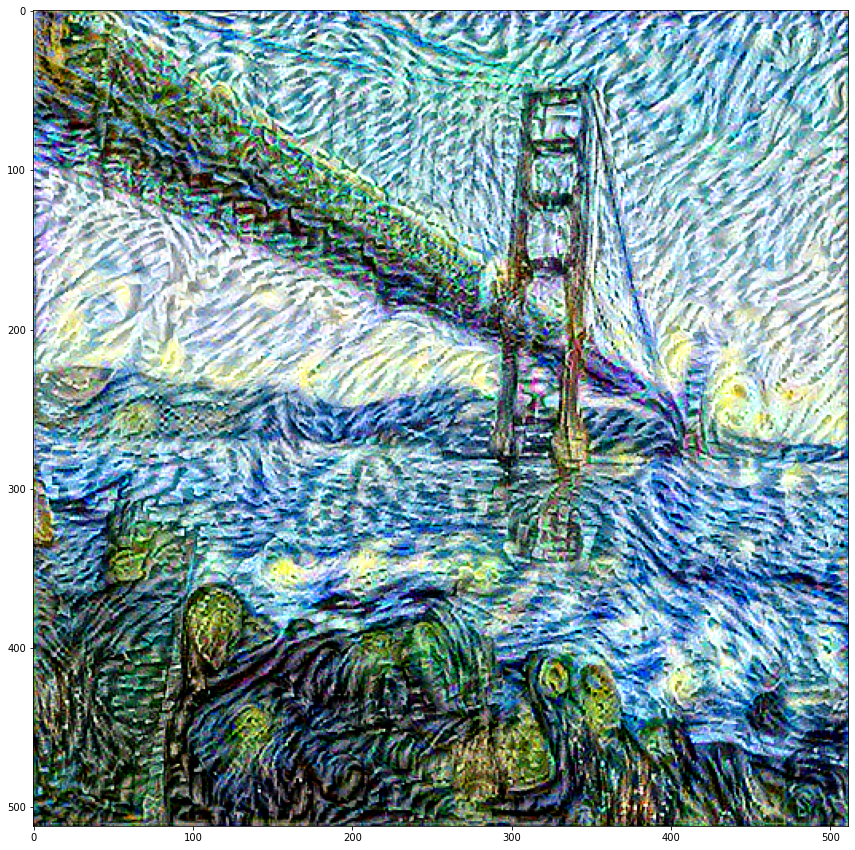

In [55]:
plt.figure(figsize = (15,15))
plt.imshow(deprocessed_best_image[0]/255)

## Wow! What a beautiful mixture!, Guess A.I. is better painter than me atleast....

### Here is a short clip of transformation :

In [57]:
from matplotlib.animation import FuncAnimation

In [59]:


fig, ax = plt.subplots(figsize=(10, 10))
def update(i):
    im_normed = images[i].numpy().reshape((512,512,3))/255
    ax.imshow(im_normed)
    ax.set_title("Loss: {}".format(losses[i]), fontsize=20)
    ax.set_axis_off()
anim = FuncAnimation(fig, update, frames=np.arange(0, len(images)), interval=50)
anim.save('style_transfer.mp4', dpi=80, writer='ffmpeg')
plt.close()

import importlib

place_video('style_transfer.mp4')

